The project involves training, via scikit-learn, a face recognition model for a digital camera that will therefore have limited resources. After training we will need to export the model via joblib and create a pipeline that given an input image will output the coordinates of the boxes containing the detected faces. We begin by importing all the necessary libraries; we will make special use of OpenCV and scikit-learn.

In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import os
import cv2
import imutils
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
import matplotlib.pyplot as plt
import joblib
from imutils.object_detection import non_max_suppression

We create a function to load images into memory and preprocess them properly before feeding them to the model. The function takes as input the folder path, initializes a list and checks that the file is an image with the extension .png, .jpg, .jpeg, then opens the file in grayscale and applies the various preprocessing steps:

- resizes the image to 128x128
- histogram equalization is then applied, a technique for improving the contrast of an image so that details are more visible in dark or overexposed images.
- Features are extracted from the image using [HOG (Histogram of Oriented Gradients)](https://medium.com/@dnemutlu/hog-feature-descriptor-263313c3b40d).  HOG is a feature extraction technique based on the calculation of image gradients (intensity changes) for each pixel, I chose it because of its excellent balance between performance and computational complexity.

This process is repeated for each image and the relevant features are added to the images list which will be returned when all the images in the folder are preprocessed.

In [2]:
def load_images_from_folder(folder):
    """
    Takes as input the folder path, applies preprocessing, and returns an array
    numpy containing the features of each image
    """
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                img = cv2.equalizeHist(img)
                hog_features = hog(img)
                images.append(hog_features)
    return images

We then go to load the images into memory, create two variables faces, containing faces photos, and no faces, containing photos of various objects. Both variables will contain the features of about 3000 images. The images of faces were randomly extracted from the dataset [FFHQ 256x256](https://www.kaggle.com/datasets/rahulbhalley/ffhq-256x256) while those concerning objects from the dataset [COCO](https://cocodataset.org/#home), also randomly extracted.

In [3]:
faces = load_images_from_folder('faces/')
no_faces = load_images_from_folder('no_faces/')

We then go on to: 
- Create the labels, assigning 1 to faces and 0 to no_faces.
- Create the dataset by merging faces and no_faces
- Transform the dataset and labels into numpy arrays

In [4]:
labels = [1]*len(faces) + [0]*len(no_faces)
data = faces + no_faces
data = np.array(data)
labels = np.array(labels)

Let's create train and test datasets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
X_train[0].shape #Numero delle features

(15876,)

Given the few computational resources and the large number of features we are going to use an SVC model with kernel linear, to optimize even more we use GridSearchCV to find the value of the C parameter that gives us the highest accuracy.

In [6]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'class_weight': ['balanced']
}

svc = SVC()
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Migliori parametri trovati:", best_params)
accuracy = grid_search.best_score_
print("Accuratezza con i migliori parametri:", accuracy)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

Migliori parametri trovati: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
Accuratezza con i migliori parametri: 0.9989648033126294


We get the highest accuracy with C=0.1
Let's take a look at the classification report

In [7]:
predictions = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:", classification_report(y_test, predictions))

Accuracy: 0.9991721854304636
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       567
           1       1.00      1.00      1.00       641

    accuracy                           1.00      1208
   macro avg       1.00      1.00      1.00      1208
weighted avg       1.00      1.00      1.00      1208



In [8]:
predictions = best_model.predict(X_train)
print("Accuracy:", accuracy_score(y_train, predictions))
print("Classification Report:", classification_report(y_train, predictions))

Accuracy: 1.0
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2452
           1       1.00      1.00      1.00      2379

    accuracy                           1.00      4831
   macro avg       1.00      1.00      1.00      4831
weighted avg       1.00      1.00      1.00      4831



We see some very optimistic metrics, so we check for overfitting via StratifiedKFold

In [9]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
print(cross_val_score(best_model, data, labels, cv=kfold, scoring='accuracy'))

[0.99917219 0.99834437 0.99917219 0.99751656 0.9991715 ]


We get similar results for all folds, so there is no presence of overfitting.
We then go on to export our model via joblib

In [10]:
joblib.dump(best_model, 'model-128.joblib')

['model-128.joblib']

Now that we have created our model we need a function that will be able to recognize faces in photos, to do this we are going to implement a function for the [image pyramid](https://pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/) that will allow us to have our image at multiple scales so that we can identify faces that are at different distances. We will then implement a [sliding window](https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/) that will allow us, by scrolling along the entire photo, to get windows to pass to our model looking for faces

In [11]:
def pyramid(image, scale=1.5, minSize=(128, 128)):
	yield image
	while True:
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		yield image
        
def sliding_window(image, stepSize, windowSize):
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

Let us now define two functions the first to preprocess the image given as input and then extract features and the second that will allow us to detect faces.
In the detect_faces function we are going to use both pyramid and sliding window to detect faces regardless of their distance and size. Once we have detected them and recorded their coordinates we will go to apply [NonMaximumSuppression](https://pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/), a process that filters out multiple predictions of overlapping objects keeping only the one with the highest score.The implementation of NMS was taken from the imutils library created by Adrian Rosebrock, author of the [pyimagesearch](https://pyimagesearch.com/) blog. The function returns the coordinates of the bounding boxes selected by NMS.

In [12]:
def preprocess_image(image):
    image = cv2.equalizeHist(image)
    img_hog = hog(image)
    return img_hog

def detect_faces(image_path):
    """
    Takes the path of an image as input, defined the size of the window
    starts sliding through sliding windows on the image at various scales. Each window
    is passed to the model, which decides whether to classify it as a face, if so
    the coordinates of the window, multiplied by the appropriate scale, are added to a
    list. A NonMaximumSuppression will finally be performed to decrease the number of boxes.
    The function returns the coordinates of the boxes selected by the NMS.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    (winW, winH) = (128, 128)

    face_coordinates = []

    for resized in pyramid(image, scale=1.5):
        for (x, y, window) in sliding_window(resized, stepSize=16, windowSize=(winW, winH)):
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
            image_preprocessed = preprocess_image(window)
            image_preprocessed_2d = image_preprocessed.reshape(1, -1)
            scale = image.shape[0]/resized.shape[0]
            if best_model.decision_function(image_preprocessed_2d) > 0.3:
                face_coordinates.append((x*scale, y*scale, (x + winW)*scale, (y + winH)*scale))

    face_coordinates_np = np.array(face_coordinates)
    nms_results = non_max_suppression(face_coordinates_np)

    return nms_results

Let's export our pipeline:

In [13]:
joblib.dump(detect_faces, 'face_detection_pipeline.joblib')

['face_detection_pipeline.joblib']

Now let's verify that our model and pipeline work:

In [23]:
best_model = joblib.load('model-128.joblib')
face_detection_pipeline = joblib.load('face_detection_pipeline.joblib')

Then let's create a function that will allow us to show bounding boxes containing faces within the image:

In [15]:
def visualize_boxes(img_path, coordinates_boxes):
    """
    It takes as input the path to the image, the coordinates of the boxes found within it
    inside and prints them out on the screen.
    """
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for (x1, y1, x2, y2) in coordinates_boxes:
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 5)

    plt.imshow(img_rgb)
    plt.axis('off')  
    plt.show()

Let's test its operation with 3 photos containing faces and 1 without faces in it

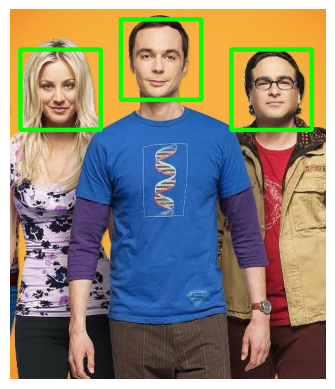

In [16]:
image_path = 'the-big.png'
face_detect_results = face_detection_pipeline(image_path)
visualize_boxes(image_path, face_detect_results)

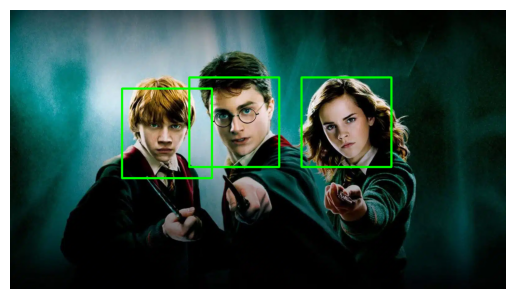

In [25]:
image_path = 'harry potter.jpeg'
face_detect_results = face_detection_pipeline(image_path)
visualize_boxes(image_path, face_detect_results)

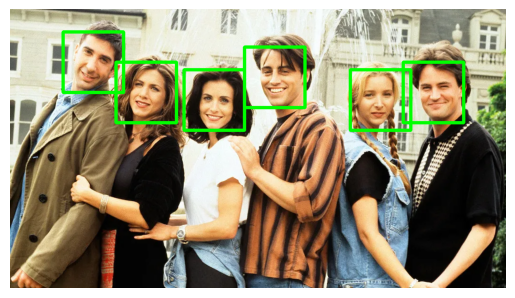

In [24]:
image_path = 'friends.jpg'
face_detect_results = face_detection_pipeline(image_path)
visualize_boxes(image_path, face_detect_results)

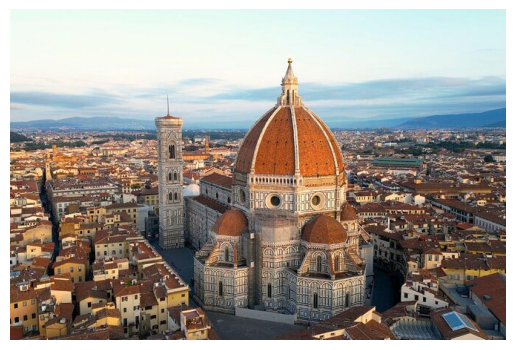

In [21]:
image_path = 'duomo_firenze.jpeg'
face_detect_results = face_detection_pipeline(image_path)
visualize_boxes(image_path, face_detect_results)

Our model and pipeline are working correctly!